In [46]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from kmodes.kmodes import KModes
import os
from collections import Counter

In [47]:
def read_files():
    """
    Reads in all the relevant files and returns them as dataframes
    """
    X = pd.read_csv('/Users/Aansh/Documents/Brown /Research/AIMed/data/x_y_with_lace.csv')
    Y = pd.read_csv('/Users/Aansh/Documents/Brown /Research/AIMed/data/y_more_no_df_clean.csv')
    X_ICD9 = pd.read_csv('/Users/Aansh/Documents/Brown /Research/AIMed/data/patient_icd9.csv')
    icd9_d = pd.read_csv('/Users/Aansh/Documents/Brown /Research/AIMed/data/DIAGNOSES_ICD.csv')
    codes_file = open('/Users/Aansh/Documents/Brown /Research/AIMed/icd9/codes.json')
    codes = json.load(codes_file)
    return X, X_ICD9, icd9_d, codes_file, codes

def map_disease_to_parent(codes):
    """
    Maps each disease to parent in ICD9 hierarchy. In absence of a parent, maps to None.
    Returns mapping of parents to children and nodes to their parents
    """
    node_to_parent = {}
    parent_to_child = {} 
    for i in range(len(codes)):
        grouping = codes[i]
        parent = None
        for j in range(len(grouping)):
            disease_classification = grouping[j]
            code = disease_classification['code']
            depth = disease_classification['depth']
            if depth == 1: parent = code
            node_to_parent[code] = parent
            curr_children = parent_to_child.get(parent, [])
            curr_children.append(code)
            parent_to_child[parent] = curr_children
    return parent_to_child, node_to_parent

def generate_intervals(parent_to_child):
    """
    Generates intervals for ICD9 codes to group codes in
    """
    intervals = []
    def split_intervals(key):
        for i in range(len(key)):
            if key[i] == "-": return key[:i-1], key[i+1:]
    for key, _ in parent_to_child.items():
        if key: intervals.append((split_intervals(key), key))
    return intervals

def get_parent_cluster(code, intervals):
    """
    Returns the parent cluster for a particular code. 
    case 1: code begins with an E -> parent is None
    case 2: code begins with an V -> parent is None
    case 3: code is purely numerical then should exist within intervals
    """
    if code[0] == "E" or code[0] == "V":
        return None
    for interval in intervals:
        beginning = int(interval[0][0])
        end = int(interval[0][1])
        parent_cluster = interval[1]
        if int(code[:3]) >= beginning and int(code[:3]) <= end:
            return parent_cluster
    print("Bad Code:" + code[:3])
    return None    

def get_all_subject_IDs(X_ICD9):
    """
    Returns set of all subject IDs in the dataset
    """
    all_subjects = set()
    for index, row in X_ICD9.iterrows(): all_subjects.add(row['SUBJECT_ID'])
    return all_subjects
        
def get_patient_clusters(icd9_d, X_ICD9, parent_to_child):
    """
    Returns mapping of subjects to their parent cluster for most severe condition,
    and mapping of the number of patients within each cluster.
    """
    icd9 = set()
    patients_in_clusters = {}
    not_exist = set()
    intervals = generate_intervals(parent_to_child)
    hadm_ids = []
    clusters = []
    all_subjects = get_all_subject_IDs(X_ICD9)
    for index, row in icd9_d.iterrows():
        subject_id = row['SUBJECT_ID']
        hadm_id = row['HADM_ID']
        if subject_id not in all_subjects:
            continue
        if row["SEQ_NUM"] == 1.0:
            severe_code = row["ICD9_CODE"]
            icd9_parent = get_parent_cluster(severe_code, intervals)
            hadm_ids.append(hadm_id)
            clusters.append(icd9_parent)
            patients_in_clusters[icd9_parent] = patients_in_clusters.get(icd9_parent, 0) + 1
    dict_to_df = {"hadm_id": hadm_ids, "cluster": clusters}
    return patients_in_clusters, dict_to_df

def add_cluster_to_dataframe(X, dict_to_df):
    hadm_icd9_df = pd.DataFrame.from_dict(dict_to_df)
    X_with_clusters = X.merge(hadm_icd9_df, left_on='hadm_id', right_on='hadm_id')
    return X_with_clusters

def create_cluster_csv(X_with_clusters, patients_in_clusters):
    for c in X_with_clusters['cluster'].unique():
        X_file_name = 'X_cluster_{0}.csv'.format(c) 
        Y_file_name = 'Y_cluster_{0}.csv'.format(c) 
        X_copy = X_with_clusters.copy()
        Y = X_with_clusters[X_with_clusters['cluster'] == c]['label']
        X_copy = X_copy[X_copy['cluster'] == c].drop(['label'], axis=1)
        X_copy[X_copy['cluster'] == c].to_csv(X_file_name, sep=',', index=False)
        Y.to_csv(Y_file_name, sep=',', index=False)
    return True

def main(): 
    X, X_ICD9, icd9_d, codes_file, codes = read_files()
    X = X.drop(['LACE', 'sofa'], axis=1)
    parent_to_child, node_to_parent = map_disease_to_parent(codes)
    patients_in_clusters, dict_to_df = get_patient_clusters(icd9_d, X_ICD9, parent_to_child)
    X_with_clusters = add_cluster_to_dataframe(X, dict_to_df)
    create_cluster_csv(X_with_clusters, patients_in_clusters)

In [79]:
X, X_ICD9, icd9_d, codes_file, codes = read_files()
X = X.drop(['LACE', 'sofa'], axis=1)

In [80]:
parent_to_child, node_to_parent = map_disease_to_parent(codes)

In [81]:
patients_in_clusters, dict_to_df = get_patient_clusters(icd9_d, X_ICD9, parent_to_child)

In [82]:
X_with_clusters = add_cluster_to_dataframe(X, dict_to_df)

In [ ]:
create_cluster_csv(X_with_clusters, patients_in_clusters)

In [99]:
def cluster_clusters(X, patient_icd9):
    """
    Use K-Modes to cluster hierarchies together
    
    1. generate one hot encoding for bag of words
        - map each cluster to a unique index 
        - 
    """ 
    clusters = list(patient_icd9.keys())
    new_clusters = []
    for c in clusters:
        if c:
            new_clusters.append(c)
    clusters = new_clusters
    clusters.sort()
    clusters.append(None)
    cluster_to_index = {}
    for i, cluster in enumerate(clusters):
        cluster_to_index[cluster] = i
    num_clusters = len(clusters)
    bow = np.zeros((X.shape[0], num_clusters))
    for index, row in X.iterrows():
        i = cluster_to_index[row['cluster']]
        bow[index, i] = 1
    Sum_of_squared_distances = []
    K = range(1,20)
    for k in K:
        km = KModes(n_clusters=3, init='Huang', verbose=1)
        clusters = km.fit_predict(bow)
        Sum_of_squared_distances.append(km.cost_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 30336.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 32637.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 29962.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 25940.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 32839.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 26808.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 32033.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration:

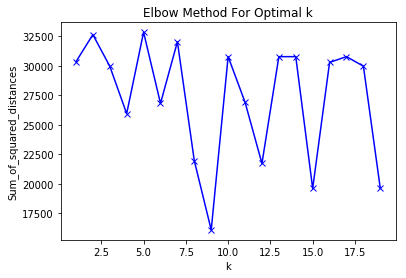

In [100]:
cluster_clusters(X_with_clusters, patients_in_clusters)